## Setup

We'll use [Ollama](https://ollama.ai/) to access a local LLM:

* Download [Ollama app](https://ollama.ai/).
* Pull your model of choice, e.g.: `ollama pull llama3`

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a vectorstore with [Nomic local embeddings](https://blog.nomic.ai/posts/nomic-embed-text-v1) or, optionally, OpenAI embeddings.


Let's install our required packages and set our API keys:

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("TAVILY_API_KEY")


In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = "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"


In [8]:
import whisper
model = whisper.load_model("small")

C:\Users\pierr\AppData\Local\Programs\Python\Python312\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, m

In [29]:
import os
from pathlib import Path

def process_audio_files(directory_path):
    # Convert to Path object for better cross-platform compatibility
    audio_dir = Path(directory_path)
    
    # Ensure directory exists
    if not audio_dir.exists():
        raise FileNotFoundError(f"Directory not found: {directory_path}")
    
    # Load Whisper model (adjust size if needed)
    model = whisper.load_model("small")

    # Create or open output file in append mode
    with open("D:\\project\\output 1.txt", "a", encoding="utf-8") as output_file:
        # Iterate through all files in directory
        for audio_file in audio_dir.iterdir():
            if audio_file.is_file():  # Make sure it's a file, not a subdirectory
                try:
                    # Get the transcription
                    transcription = model.transcribe(str(audio_file))
                    
                    # Write to output file with file name for reference
                    output_file.write(f"\n\n******************************\n\n\n")
                    output_file.write(transcription["text"])  # Fix: Extract text from dict
                    
                    print(f"Successfully processed: {audio_file.name}")
                    
                except Exception as e:
                    print(f"Error processing {audio_file.name}: {str(e)}")
                    # Optionally log errors to output file
                    output_file.write(f"\n\nError processing {audio_file.name}: {str(e)}\n")

In [30]:
if __name__ == "__main__":
    # Specify the directory path
    audio_directory = "D:/project/test"
    
    try:
        process_audio_files(audio_directory)
        print("Processing completed. Results saved to output.txt")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

C:\Users\pierr\AppData\Local\Programs\Python\Python312\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, m

Successfully processed: WhatsApp Audio 2024-11-16 at 08.55.49_42236c64.mp3
Successfully processed: WhatsApp Audio 2024-11-16 at 08.55.49_f2260982.mp3
Processing completed. Results saved to output.txt


### LLM

You can select from [Ollama LLMs](https://ollama.com/library).

In [13]:
local_llm = "llama3.2:3b"
model_tested = "llama3.2:3b"
metadata = f"CRAG, {model_tested}"

## Create Index

Let's index 3 blog posts.

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings  # local
from langchain.schema import Document
#
with open("D:\\project\\output.txt", 'r', encoding='utf-8') as file:
    text_content = file.read()
    
docs_list = [Document(page_content=text_content)]


text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)



# Embedding
embedding=NomicEmbeddings(
    model="nomic-embed-text-v1.5",
    inference_mode="local",
)



# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

Embedding texts: 100%|███████████████████████████████████████████████████████████| 239/239 [12:17<00:00,  3.09s/inputs]


## Define Tools

In [15]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION.
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "Who won the 2024 IPL?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

Embedding texts: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54inputs/s]


{'score': 'no'}


In [16]:
##

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are Shobana. 
    
    Use the following expcerpts from shobana herself to answer the question.

    Answer the question in the shobana's style.
    
    If you don't know the answer, say that you dont know it. 

    Keep the answers as short as possible, two sentences maximum.
    
    Always answer in the first person as shobana herself.
    
    Make no reference under any circumstances to any documents, unless specifically asked :
    
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

I don't know who won the 2024 IPL. I'm not really into sports, to be honest!


In [17]:
import torch
from bark import SAMPLE_RATE, generate_audio
from scipy.io.wavfile import write

class BarkTTS:
    def __init__(self, speaker="v2/en_speaker_0"):
        self.speaker = speaker

    def generate_speech(self, text, output_file="output.wav"):
        print(f"Generating speech for: {text}")
        audio_array = generate_audio(text, history_prompt=self.speaker)
        
        # Save the generated audio
        write(output_file, SAMPLE_RATE, audio_array)
        print(f"Audio saved to {output_file}")

        return output_file

C:\Users\pierr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from bark_tts import BarkTTS

# Initialize Bark TTS
tts = BarkTTS()

# Example RAG output
rag_output = "This is a test response from the RAG model."

# Generate speech
output_audio = tts.generate_speech(rag_output)

# Play the audio in Jupyter Notebook (optional)
import IPython.display as ipd
ipd.Audio(output_audio)

ModuleNotFoundError: No module named 'bark_tts'

In [23]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [24]:
from langchain_community.embeddings import HuggingFaceEmbeddings

In [28]:
import tkinter as tk
from tkinter import scrolledtext
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain.schema import Document
from langchain.chains import RetrievalQA
from langchain_community.llms import HuggingFaceEndpoint  # or your local LLM wrapper

from langchain.embeddings import FakeEmbeddings

embedding = FakeEmbeddings(size=768)


# === Load and prepare docs ===
with open("D:\\project\\output.txt", 'r', encoding='utf-8') as file:
    text_content = file.read()

docs_list = [Document(page_content=text_content)]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# === Embedding & Vector DB ===
from langchain_community.embeddings import HuggingFaceEmbeddings
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-MiniLM-L3-v2")


# === Retrieval Chain ===
retriever = vectorstore.as_retriever()
llm = LocalLlama("llama3.2:3b")
llm = HuggingFaceEndpoint(repo_id="meta-llama/Meta-Llama-3-8B", temperature=0.7)  # or your local model
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

# === GUI Setup ===
def ask_question():
    query = question_entry.get("1.0", tk.END).strip()
    if not query:
        output_box.delete("1.0", tk.END)
        output_box.insert(tk.END, "Please enter a question.")
        return
    response = qa_chain.run(query)
    output_box.delete("1.0", tk.END)
    output_box.insert(tk.END, response)

root = tk.Tk()
root.title("RAG Q&A")

tk.Label(root, text="Ask a Question:").pack()

question_entry = tk.Text(root, height=4, width=80)
question_entry.pack(padx=10, pady=5)

ask_btn = tk.Button(root, text="Ask", command=ask_question)
ask_btn.pack(pady=5)

tk.Label(root, text="Answer:").pack()

output_box = scrolledtext.ScrolledText(root, height=10, width=80)
output_box.pack(padx=10, pady=5)

root.mainloop()


Error while downloading from https://cdn-lfs.hf.co/sentence-transformers/paraphrase-MiniLM-L3-v2/cf1e4e2d420c664973037c3c73125d7a8fc69952495093ef8f50596f8943a433?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1743750413&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0Mzc1MDQxM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9zZW50ZW5jZS10cmFuc2Zvcm1lcnMvcGFyYXBocmFzZS1NaW5pTE0tTDMtdjIvY2YxZTRlMmQ0MjBjNjY0OTczMDM3YzNjNzMxMjVkN2E4ZmM2OTk1MjQ5NTA5M2VmOGY1MDU5NmY4OTQzYTQzMz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=cR-J3bBxQ4leO2OBmGxQhOb6ttEM2CX7WJs1OP8eDclz2NrTDTLGiZO-OagmYKZrZtBFTS18aQ%7Ea8lZwoPAG9inVqRG57G748qQ9wY871D2nTCvkNf8iUBa3S27wJiCjiqAiKwfjetxL%7EjZyIDK9DeYNG%7EEaxADyeQkHCk%7E0lQzlPNVah3AFFJyZQV8f7JwawpVo%7ElGi-c91gx-rRdyv6EVWxA9vrvoapMvFjrPhwnQ9RtplrOhFswGg5WvhdeTh0nnpql6wP8Zm-Bzsc1Hbd9MYt-V-Ijqt4wwLi9L8dhLpbQYXGIzcFWmAgk7RDVQfemcbXVnS5ZzKmn

ConnectionError: HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Read timed out.

In [23]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Create the Graph 

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

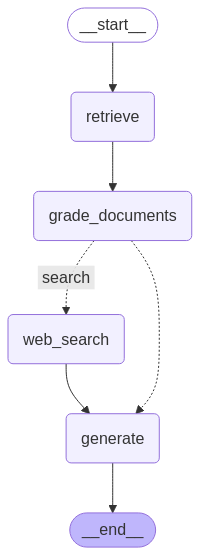

In [24]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
import uuid


def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "what do you do in your free time?"}
response = predict_custom_agent_local_answer(example)
response

Embedding texts: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.34inputs/s]


{'response': "My free time is precious to me! I love roaming the streets with friends, sharing stories and enjoying little adventures - it's my way of feeling free and connected to the world around me.",
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

Trace: 

https://smith.langchain.com/public/88e7579e-2571-4cf6-98d2-1f9ce3359967/r

## Evaluation

Now we've defined two different agent architectures that do roughly the same thing!

We can evaluate them. See our [conceptual guide](https://docs.smith.langchain.com/concepts/evaluation#agents) for context on agent evaluation.

### Response

First, we can assess how well [our agent performs on a set of question-answer pairs](https://docs.smith.langchain.com/tutorials/Developers/agents#response-evaluation).

We'll create a dataset and save it in LangSmith.

In [26]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "do you preffer poori or chapathi?",
        "I prefer poori over chapathi because I love its distinct charm, golden brown color, crisp edges, and soft center, which make it feel like a celebration every time I eat it. It also retains its softness and flavor for a long time, making it a special treat that adds a spineless taste to my life.",
    ),
    (
        "so, how is bangalore so far?",
        "I love living in Bangalore - it's a great feeling to be surrounded by so much energy and life. The city has a way of making me feel at home, even after being here for a while.",
    ),
    (
        "how do you feel about yourself?",
        "I'm not sure how I feel about myself, but I care deeply about others and want to be someone who brings comfort and support to those around me.",
    ),
    (
        "Who won the 2024 IPL season?",
        "I don't know who won the 2024 IPL, I'm a writer, not a sports expert!",
    )
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

C:\Users\pierr\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


LangSmithAuthError: Authentication failed for /datasets. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/datasets?limit=1&name=Corrective+RAG+Agent+Testing', '{"detail":"Invalid token"}')

Now, we'll use an `LLM as a grader` to compare both agent responses to our ground truth reference answer.

[Here](https://smith.langchain.com/hub/rlm/rag-answer-vs-reference) is the default prompt that we can use.

We'll use `gpt-4o` as our LLM grader.


In [9]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy and stylistic simlarity between answer an content in {text_content}
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

### Trajectory

Second, [we can assess the list of tool calls](https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory) that each agent makes relative to expected trajectories.

This evaluates the specific reasoning traces taken by our agents!

In [10]:
from langsmith.schemas import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]


def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned
    """
    tool_calls = [tc['name'] for m in messages['messages'] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls


def check_trajectory_react(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    messages = root_run.outputs["messages"]
    tool_calls = find_tool_calls_react(messages)
    print(f"Tool calls ReAct agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}


def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [11]:
from langsmith.evaluation import evaluate

experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_local_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=1,  # Use when running locally
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'custom-agent-llama3-8b-answer-and-tool-use-d6006159' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/a8b9273b-ca33-4e2f-9f69-9bbc37f6f51b/compare?selectedSessions=83c60822-ef22-43e8-ac85-4488af279c6f




0it [00:00, ?it/s]

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom a

We can see the results benchmarked against `GPT-4o` and `Llama-3-70b` using `Custom` agent (as shown here) and ReAct.

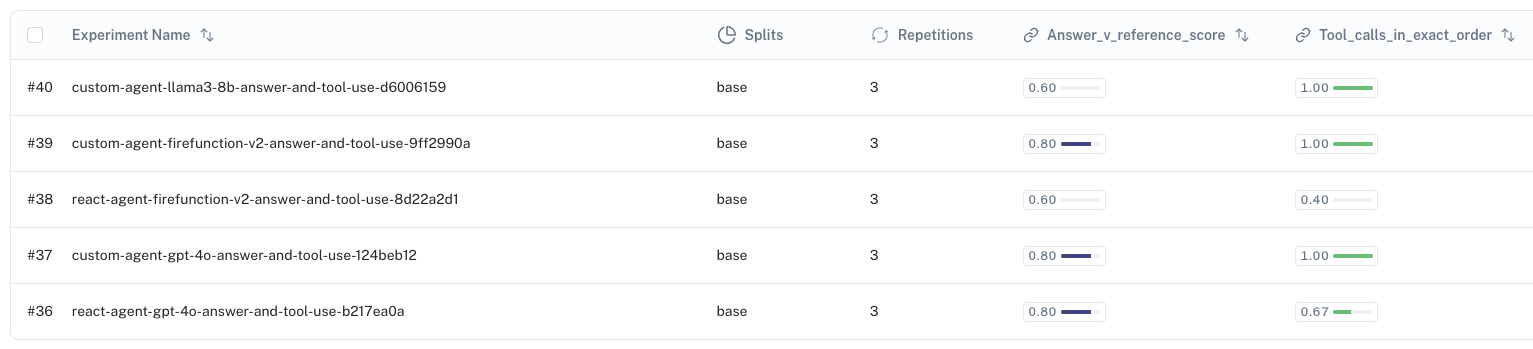

The `local custom agent` performs well in terms of tool calling reliability: it follows the expected reasoning traces.

However, the answer accuracy performance lags the larger models with `custom agent` implementations.